press ctrl + / to comment out/in multiple lines

In [1]:
# to print all lines in the cell
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from keras import layers
from keras import regularizers
from keras import backend as K

from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

## using processed_df for all deep learning models

In [ ]:
# processed + stemmed
url = 'https://raw.githubusercontent.com/uhhiitsphilia/CDS-Project/main/data/raw_data/stem_review_Henry.csv?token=AR3M6JPHPV5G4IK6RFB4RQK7YWOJY'
stem_df = pd.read_csv(url)

In [ ]:
# processed + lemmatized
url = 'https://raw.githubusercontent.com/uhhiitsphilia/CDS-Project/main/data/raw_data/lem_review_Henry.csv?token=AR3M6JJK76CGRVZMGNPI5UC7YWOOK'
lem_df = pd.read_csv(url)

In [ ]:
# processed only
url = 'https://raw.githubusercontent.com/uhhiitsphilia/CDS-Project/main/data/raw_data/processed_only_review_Henry.csv?token=AR3M6JMSP2OV5JJVDP5Z2DK7ZYY66'
processed_df = pd.read_csv(url)

## Functions for plotting model's 
accuracy history <br>
loss history <br>
best model (prints test accuracy and confusion matrix)


In [ ]:
def plot_acc_history(history1,history2,history3):
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])

    plt.plot(history2.history['accuracy'])
    plt.plot(history2.history['val_accuracy'])

    plt.plot(history3.history['accuracy'])
    plt.plot(history3.history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_1','test_1','train_2','test_2','train_3','test_3'], loc='lower left')
    plt.show()
    return None

In [ ]:
def plot_loss_history(history1,history2,history3):
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])

    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])

    plt.plot(history3.history['loss'])
    plt.plot(history3.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_stem','test_stem','train_lem','test_lem','train_raw','test_raw'], loc='lower right')
    plt.show()
    return None

In [ ]:
def plot_best_model(raw_test,labels_test,model_no):
    full_model_name = "best_model" + str(model_no) + ".hdf5"
    best_model = keras.models.load_model(full_model_name)
    test_loss, test_acc = best_model.evaluate(raw_test, labels_test, verbose=1) #verbose is to show progress
    print('Model accuracy: ',test_acc)
    print('Predicting...')
    predictions = best_model.predict(raw_test, verbose=1)

    #plot confusion_matrix
    matrix = confusion_matrix(labels_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
    conf_matrix = pd.DataFrame(matrix, index = ['Negative','Positive'],columns = ['Negative','Positive'])
    #Normalizing
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
    return None

## NLP AUG

In [ ]:
!pip install nlpaug 
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action
import random

     |████████████████████████████████| 389kB 9.0MB/s 


### extracting segment of postive and negtive reviews for augmenting

In [ ]:
df_temp1 = pd.DataFrame(processed_df.iloc[:1250,:])
df_temp2 = pd.DataFrame(processed_df.iloc[12500:13750,:])
df_temp = df_temp1.append(df_temp2)
df_temp
df_temp['sentiment'].value_counts()

### NLP AUG technique 1 - randomly replace character in multiple words in review

In [ ]:
aug_1 = []
aug_2 = []
aug_3 = []
aug_4 = []
aug_5 = []

In [ ]:
%timeit 
B = []
aug1 = nac.OcrAug()
aug2 = naw.SynonymAug(aug_src='wordnet')
aug3 = nac.RandomCharAug(action="insert")
aug4 = nac.RandomCharAug(action="substitute")
aug5 = naw.SpellingAug()
random.seed(30)
A = time.time()
for i in range(25000):
  aug_1.append(aug1.augment(processed_df.iloc[i,0], n=3))
  # aug_2.append(aug2.augment(processed_df.iloc[i,0], n=3))
  # aug_3.append(aug3.augment(processed_df.iloc[i,0], n=1))
  # aug_4.append(aug4.augment(processed_df.iloc[i,0], n=1))
  # aug_5.append(aug5.augment(processed_df.iloc[i,0], n=1))
  print(i)
B.append(time.time()-A)

print(B)

In [ ]:
flat_list = []
for sublist in aug_1:
    for item in sublist:
        flat_list.append(item)
len(flat_list)
len(aug_1)

In [ ]:
aug_all = aug_1 + aug_2 + aug_3 + aug_4 + aug_5 # 125 000
len(aug_all)

### creating labels and dataframe for augmented data

In [ ]:
list_labels = list(processed_df.iloc[:25000,1]) + list(processed_df.iloc[:25000,1]) + list(processed_df.iloc[:25000,1])
list_labels.count('negtive') # for checking
list_labels.count('postive')

In [ ]:
df_temp = pd.DataFrame({'aug_1_review' : flat_list})
df_temp['sentiment'] = list_labels
df_temp = df_temp.append(processed_df) #append original train and test

In [ ]:
df_temp = df_temp.drop("aug1",axis=1)
df_temp

### downloading augmented reviews

In [ ]:
df_for_download = df_temp.iloc[:75000,:]
df_for_download.to_csv("./75kaug1.csv", sep=',',index=False)

In [ ]:
from google.colab import files
files.download('75kaug1.csv')

### IMPORTING augmented reviews

In [ ]:
# processed only
url = 'https://raw.githubusercontent.com/uhhiitsphilia/CDS-Project/main/data/raw_data/75kaug_1_Henry.csv?token=AR3M6JJ2Y23XLOM4G33RNUK7ZMPMW'
augmented_df = pd.read_csv(url)
augmented_df['sentiment'].value_counts()

negtive    37500
postive    37500
Name: sentiment, dtype: int64

### extracting segment of postive and negtive augmented reviews for training

In [ ]:
df_temp1 = pd.DataFrame(augmented_df.iloc[:1250,:])
df_temp2 = pd.DataFrame(augmented_df.iloc[12500:13750,:])
df_temp = df_temp1.append(df_temp2)
df_temp
df_temp['sentiment'].value_counts()

none_review sentiment
0      Bromwell High is a cartoon comedy. 1t ran at t...   postive
1      Bromwell High is a cartoon comedy. It ran at t...   postive
2      Bromwell High is a cartoon comedy. It ran at t...   postive
3      Homelessness (or Houselessness as George Carli...   postive
4      Homelessness (or Houselessness as George Carli...   postive
...                                                  ...       ...
13745  Cinderella is a beautiful young woman who is t...   negtive
13746  Cinderella In my opinion greatest love story e...   negtive
13747  Cindeke11a In my opinion greatest love story e...   negtive
13748  Cinderella In my opinion greatest love story e...   negtive
13749  The story of Cinderella is one of my favorites...   negtive

[2500 rows x 2 columns]

postive    1250
negtive    1250
Name: sentiment, dtype: int64

## Embedding layers (use embedding for processed only for DL models)

### embedding layer for processed + Stemmed reviews

In [ ]:
data_stem_train = np.array(stem_df.iloc[:,0])
data_stem_train

In [ ]:
max_words = 5000 # top x frequent words
max_len = 200 # max len of each review

tokenizer_stem = Tokenizer(num_words=max_words)
tokenizer_stem.fit_on_texts(data_stem_train)
sequences_stem = tokenizer_stem.texts_to_sequences(data_stem_train)
review_stem = pad_sequences(sequences_stem, maxlen=max_len)
review_stem

### embedding layer for processed + Lemmatized reviews

In [ ]:
data_lem_train = np.array(lem_df.iloc[:,0])
data_lem_train

In [ ]:
max_words = 5000 # top x frequent words
max_len = 200 # max len of each doc/tweet

tokenizer_lem = Tokenizer(num_words=max_words)
tokenizer_lem.fit_on_texts(data_lem_train)
sequences_lem = tokenizer_lemma.texts_to_sequences(data_lem_train)
review_lem = pad_sequences(sequences_lem, maxlen=max_len)
review_lem

### embedding layer for processed only reviews

In [ ]:
#df_temp contains augmented reviews
#data_train = df_temp.append(processed_df) #append original train and test
data_train_array = np.array(processed_df.iloc[:,0])

In [ ]:
len(data_train_array)

50000

In [ ]:
max_words = 5000 # top x frequent words
max_len = 200 # max len of each doc/tweet

tokenizer_raw = Tokenizer(num_words=max_words)
tokenizer_raw.fit_on_texts(data_train_array)
sequences_raw = tokenizer_raw.texts_to_sequences(data_train_array)
review_raw = pad_sequences(sequences_raw, maxlen=max_len)
review_raw

array([[   0,    0,    0, ...,   11,    8,  209],
       [4046,    1,   19, ...,    5,  346,  379],
       [   0,    0,    0, ...,    6,  179,  402],
       ...,
       [ 396, 1248, 2618, ...,  124,  336,  158],
       [   0,    0,    0, ...,   61,  178,    5],
       [2062,   18,   82, ...,   14,   39, 1069]], dtype=int32)

## Assigning labels. Positive = 1 and Negative = 0.

In [ ]:
labels = np.array(processed_df['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'negtive':
        y.append(0)
    if labels[i] == 'postive':
        y.append(1)
y = np.array(y)
labels_all = tf.keras.utils.to_categorical(y, 2, dtype="float32")
del y
len(labels_all)

50000

## Generating train and test data

In [ ]:
# stem_train = review_stem[:25000]
# stem_test = review_stem[25000:]
# print(len(stem_train),len(stem_test))

# lem_train = review_lem[:25000]
# lem_test = review_lem[25000:]
# print(len(lem_train),len(lem_test))

raw_train = review_raw[:11250]
labels_train = labels_all[:11250]
print(len(raw_train),len(labels_train))

raw_test = review_raw[11250:]
labels_test = labels_all[11250:]
print(len(raw_test),len(labels_test))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(review_raw,labels_all,test_size = 0.2,random_state=17)
len(x_train);len(x_test)
len(y_train);len(y_test)

40000

10000

40000

10000

## simple RNN
Model 00 Simple RNN - processed + stemmed reviews <br>
Model 01 Simple RNN - processed + lemmatized reviews <br>
Model 02 Simple RNN - processed reviews

In [ ]:
model00 = Sequential()
model00.add(layers.Embedding(max_words, 15)) # 15 is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word.
model00.add(layers.SimpleRNN(40)) # 15 here have the same meaning as above
model00.add(layers.Dense(2,activation='softmax'))

model00.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint00 = ModelCheckpoint("best_model00.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history00 = model00.fit(stem_train, labels_train, epochs=10,validation_data=(stem_test, labels_test),callbacks=[checkpoint00])

In [ ]:
model01 = Sequential()
model01.add(layers.Embedding(max_words, 15)) 
model01.add(layers.SimpleRNN(40)) 
model01.add(layers.Dense(2,activation='softmax'))

model01.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint01 = ModelCheckpoint("best_model01.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history01 = model01.fit(lem_train, labels_train, epochs=10,validation_data=(lem_test, labels_test),callbacks=[checkpoint01])

In [ ]:
model02 = Sequential()
model02.add(layers.Embedding(max_words, 15)) # 15 is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word.
model02.add(layers.SimpleRNN(40)) # 15 here have the same meaning as above
model02.add(layers.Dense(2,activation='softmax'))

model02.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint02 = ModelCheckpoint("best_model02.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history02 = model02.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),batch_size=32,callbacks=[checkpoint02])

### plots

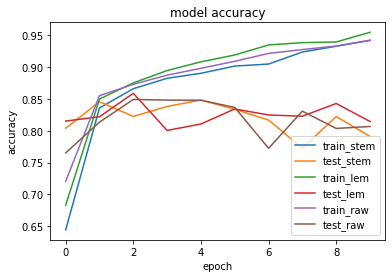

In [ ]:
plot_acc_history(history00,history01,history02)
plot_loss_history(history00,history01,history02)

### verdict: no significant differences
Using model 2 - processed only for the remaining model

## one layer LSTM
Model 10 Simple RNN - nadam optimizer <br>
Model 11 Simple RNN - adam optimizer <br>
Model 12 Simple RNN - rmsprop optimizer

In [ ]:
model10 = Sequential()
model10.add(layers.Embedding(max_words, 40))
model10.add(layers.Bidirectional(layers.LSTM(15,dropout=0.7)))
model10.add(layers.Dense(2,activation='sigmoid'))

model10.compile(optimizer='nadam',loss='binary_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint10 = ModelCheckpoint("best_model10.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history10 = model10.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32, callbacks=[checkpoint10])

Epoch 1/30
1249/1250 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.8089
Epoch 00001: val_accuracy improved from -inf to 0.88490, saving model to best_model10.hdf5
1250/1250 [==============================] - 29s 23ms/step - loss: 0.4090 - accuracy: 0.8091 - val_loss: 0.2814 - val_accuracy: 0.8849
Epoch 2/30
1248/1250 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.8823
Epoch 00002: val_accuracy improved from 0.88490 to 0.88790, saving model to best_model10.hdf5
1250/1250 [==============================] - 28s 22ms/step - loss: 0.2888 - accuracy: 0.8822 - val_loss: 0.2713 - val_accuracy: 0.8879
Epoch 3/30
1249/1250 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.8910
Epoch 00003: val_accuracy did not improve from 0.88790
1250/1250 [==============================] - 28s 22ms/step - loss: 0.2663 - accuracy: 0.8910 - val_loss: 0.3164 - val_accuracy: 0.8748
Epoch 4/30
1248/1250 [============================>.] - ETA: 

In [ ]:
model11 = Sequential()
model11.add(layers.Embedding(max_words, 40))
model11.add(layers.LSTM(15,dropout=0.7))
model11.add(layers.Dense(2,activation='sigmoid'))

model11.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint11 = ModelCheckpoint("best_model11.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history11 = model11.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32,callbacks=[checkpoint11])

Epoch 1/30
1247/1250 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8150
Epoch 00001: val_accuracy improved from -inf to 0.88440, saving model to best_model11.hdf5
1250/1250 [==============================] - 17s 13ms/step - loss: 0.4026 - accuracy: 0.8151 - val_loss: 0.2800 - val_accuracy: 0.8844
Epoch 2/30
1246/1250 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.8861
Epoch 00002: val_accuracy improved from 0.88440 to 0.88940, saving model to best_model11.hdf5
1250/1250 [==============================] - 16s 13ms/step - loss: 0.2783 - accuracy: 0.8860 - val_loss: 0.2657 - val_accuracy: 0.8894
Epoch 3/30
1247/1250 [============================>.] - ETA: 0s - loss: 0.2586 - accuracy: 0.8949
Epoch 00003: val_accuracy improved from 0.88940 to 0.89190, saving model to best_model11.hdf5
1250/1250 [==============================] - 16s 13ms/step - loss: 0.2584 - accuracy: 0.8950 - val_loss: 0.2694 - val_accuracy: 0.8919
Epoch 4/30
1250/1250 [

In [ ]:
model12 = Sequential()
model12.add(layers.Embedding(max_words, 40))
model12.add(layers.LSTM(15,dropout=0.7))
model12.add(layers.Dense(2,activation='sigmoid'))

model12.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) #changed from categorical_crossentropy to binary_crossentropy
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint12 = ModelCheckpoint("best_model12.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history12 = model12.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32,callbacks=[checkpoint12])

Epoch 1/30
1249/1250 [============================>.] - ETA: 0s - loss: 0.4093 - accuracy: 0.8177
Epoch 00001: val_accuracy improved from -inf to 0.87590, saving model to best_model12.hdf5
1250/1250 [==============================] - 15s 12ms/step - loss: 0.4092 - accuracy: 0.8177 - val_loss: 0.3083 - val_accuracy: 0.8759
Epoch 2/30
1249/1250 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.8810
Epoch 00002: val_accuracy did not improve from 0.87590
1250/1250 [==============================] - 15s 12ms/step - loss: 0.2958 - accuracy: 0.8809 - val_loss: 0.2981 - val_accuracy: 0.8682
Epoch 3/30
1248/1250 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.8873
Epoch 00003: val_accuracy did not improve from 0.87590
1250/1250 [==============================] - 15s 12ms/step - loss: 0.2783 - accuracy: 0.8874 - val_loss: 0.3010 - val_accuracy: 0.8742
Epoch 4/30
1247/1250 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.8926
Ep

In [ ]:
from google.colab import files
files.download("best_model12.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.upload()

Saving test.hdf5 to test.hdf5


{'test.hdf5': b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xc0R\x19\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\xa8\x02\x00\x00\x00\x00\x00\x00\x01\x00\x07\x00\x01\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x10\x00\x10\x00\x00\x00\x00\x00 \x03\x00\x00\x00\x00\x00\x00h\x01\x00\x00\x00\x00\x00\x00TREE\x00\x00\x01\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [ ]:
best_model99 = Sequential()
best_model99.hdf5 = keras.models.load_model("test.hdf5")
best_model99.predict(x_test)

array([[   0,    0,    0, ...,  180,   48,  117],
       [   0,    0,    0, ...,    3, 1276,   16],
       [   0,    0,    0, ...,  128,  401,   48],
       ...,
       [ 104,   15,    1, ...,    4,  123,   54],
       [   5,  102,    9, ..., 2204,  454,  398],
       [   0,    0,    0, ...,   75, 1394,   48]], dtype=int32)

### plots

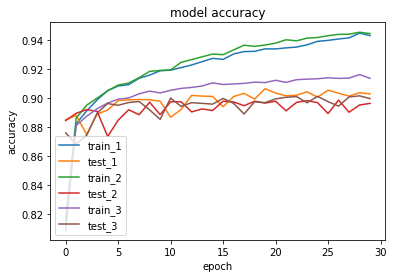

In [ ]:
plot_acc_history(history10,history11,history12)

verdict: no significant differences

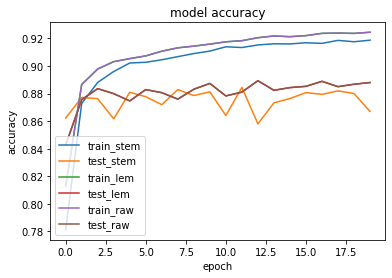

In [ ]:
plot_acc_history(history31,history32,history32)

In [ ]:
plot_best_model(raw_test,labels_test,32)

## one layer LSTM (with more changes)
Model 13 Simple RNN - more nodes per layer (0.89436) <br>
Model 14 Simple RNN - more nodes per layer (0.89092) <br>
Model 15 Simple RNN - more nodes per layer + 1 more dense layer (0.89160)<br>
Model 16 Simple RNN - more nodes per layer + 1 more dense layer + more nodes in first dense layer (0.89252)

In [ ]:
model13 = Sequential() # 0.89436
model13.add(layers.Embedding(max_words, 128))
model13.add(layers.LSTM(64,dropout=0.7))
model13.add(layers.Dense(2,activation='sigmoid'))

model13.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) 
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint13 = ModelCheckpoint("best_model13.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history13 = model13.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32,callbacks=[checkpoint13])

Epoch 1/30
1247/1250 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8255
Epoch 00001: val_accuracy improved from -inf to 0.88650, saving model to best_model13.hdf5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3907 - accuracy: 0.8256 - val_loss: 0.2842 - val_accuracy: 0.8865
Epoch 2/30
1250/1250 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8826
Epoch 00002: val_accuracy improved from 0.88650 to 0.88820, saving model to best_model13.hdf5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2917 - accuracy: 0.8826 - val_loss: 0.2970 - val_accuracy: 0.8882
Epoch 3/30
1249/1250 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8930
Epoch 00003: val_accuracy improved from 0.88820 to 0.89620, saving model to best_model13.hdf5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2683 - accuracy: 0.8930 - val_loss: 0.2554 - val_accuracy: 0.8962
Epoch 4/30
1250/1250 [

In [ ]:
model14 = Sequential() # 0.89092
model14.add(layers.Embedding(max_words, 256))
model14.add(layers.LSTM(128,dropout=0.7))
model14.add(layers.Dense(2,activation='sigmoid'))

model14.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) 
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint14 = ModelCheckpoint("best_model14.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history14 = model14.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32,callbacks=[checkpoint14])

Epoch 1/30
1250/1250 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.8231
Epoch 00001: val_accuracy improved from -inf to 0.88220, saving model to best_model14.hdf5
1250/1250 [==============================] - 32s 25ms/step - loss: 0.4032 - accuracy: 0.8231 - val_loss: 0.2833 - val_accuracy: 0.8822
Epoch 2/30
1248/1250 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.8796
Epoch 00002: val_accuracy improved from 0.88220 to 0.89310, saving model to best_model14.hdf5
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2954 - accuracy: 0.8796 - val_loss: 0.2689 - val_accuracy: 0.8931
Epoch 3/30
1248/1250 [============================>.] - ETA: 0s - loss: 0.2584 - accuracy: 0.8964
Epoch 00003: val_accuracy improved from 0.89310 to 0.89740, saving model to best_model14.hdf5
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2583 - accuracy: 0.8965 - val_loss: 0.2713 - val_accuracy: 0.8974
Epoch 4/30
1250/1250 [

In [ ]:
model15 = Sequential() # 0.89160
model15.add(layers.Embedding(max_words, 128))
model15.add(layers.LSTM(64,dropout=0.7))
model15.add(layers.Dense(15,activation='sigmoid'))
model15.add(layers.Dense(2,activation='sigmoid'))

model15.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) 
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint15 = ModelCheckpoint("best_model15.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history15 = model15.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32,callbacks=[checkpoint15])

Epoch 1/30
1250/1250 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.7788
Epoch 00001: val_accuracy improved from -inf to 0.86960, saving model to best_model15.hdf5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.4636 - accuracy: 0.7788 - val_loss: 0.3243 - val_accuracy: 0.8696
Epoch 2/30
1247/1250 [============================>.] - ETA: 0s - loss: 0.3091 - accuracy: 0.8772
Epoch 00002: val_accuracy improved from 0.86960 to 0.88170, saving model to best_model15.hdf5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3091 - accuracy: 0.8773 - val_loss: 0.2861 - val_accuracy: 0.8817
Epoch 3/30
1249/1250 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.8904
Epoch 00003: val_accuracy improved from 0.88170 to 0.88830, saving model to best_model15.hdf5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2786 - accuracy: 0.8903 - val_loss: 0.2782 - val_accuracy: 0.8883
Epoch 4/30
1247/1250 [

In [ ]:
model16 = Sequential() # 0.89252
model16.add(layers.Embedding(max_words, 128))
model16.add(layers.LSTM(64,dropout=0.7))
model16.add(layers.Dense(40,activation='sigmoid'))
model16.add(layers.Dense(2,activation='sigmoid'))

model16.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) 
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint16 = ModelCheckpoint("best_model16.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history16 = model16.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32,callbacks=[checkpoint16])

Epoch 1/30
1249/1250 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8104
Epoch 00001: val_accuracy improved from -inf to 0.87950, saving model to best_model16.hdf5
1250/1250 [==============================] - 21s 16ms/step - loss: 0.4158 - accuracy: 0.8104 - val_loss: 0.3174 - val_accuracy: 0.8795
Epoch 2/30
1247/1250 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8795
Epoch 00002: val_accuracy improved from 0.87950 to 0.88580, saving model to best_model16.hdf5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2994 - accuracy: 0.8795 - val_loss: 0.2829 - val_accuracy: 0.8858
Epoch 3/30
1248/1250 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.8923
Epoch 00003: val_accuracy improved from 0.88580 to 0.88960, saving model to best_model16.hdf5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2709 - accuracy: 0.8922 - val_loss: 0.2890 - val_accuracy: 0.8896
Epoch 4/30
1247/1250 [

### plots

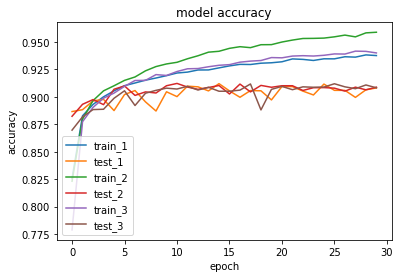

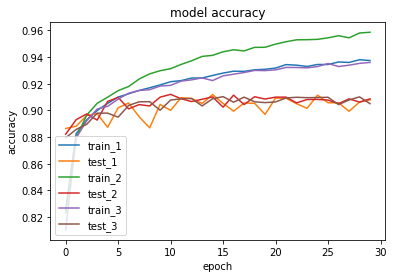

In [ ]:
plot_acc_history(history13,history14,history15)
plot_acc_history(history13,history14,history16)

### verdict: no significant difference.
re-run models 00,01,02 to compare these 2 sets of models

## one layer LSTM (with more changes)
Model 16 Simple RNN - more nodes per layer (0.89436) <br>
Model 17 Simple RNN - more nodes per layer + 1 more dense layer (0.89160)<br>
Model 18 Simple RNN - more nodes per layer + 1 more dense layer + more nodes in first dense layer (0.89252)

In [ ]:
model17 = Sequential() # 0.88680
model17.add(layers.Embedding(max_words, 1024))
model17.add(layers.LSTM(128,dropout=0.7))
model17.add(layers.Dense(20,activation='sigmoid'))
model17.add(layers.Dense(2,activation='sigmoid'))

model17.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) 
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint17 = ModelCheckpoint("best_model17.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history17 = model17.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),batch_size=128,callbacks=[checkpoint17])

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.7728
Epoch 00001: val_accuracy improved from -inf to 0.85720, saving model to best_model17.hdf5
313/313 [==============================] - 43s 138ms/step - loss: 0.4826 - accuracy: 0.7728 - val_loss: 0.3540 - val_accuracy: 0.8572
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8693
Epoch 00002: val_accuracy improved from 0.85720 to 0.86480, saving model to best_model17.hdf5
313/313 [==============================] - 44s 140ms/step - loss: 0.3317 - accuracy: 0.8693 - val_loss: 0.3319 - val_accuracy: 0.8648
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.8928
Epoch 00003: val_accuracy improved from 0.86480 to 0.86490, saving model to best_model17.hdf5
313/313 [==============================] - 44s 140ms/step - loss: 0.2741 - accuracy: 0.8928 - val_loss: 0.3240 - val_accuracy: 0.8649
Epoch 4/10
313/313 [===========

In [ ]:
model18 = Sequential() # 0.88120
model18.add(layers.Embedding(max_words, 256))
model18.add(layers.LSTM(128,return_sequences=True,dropout=0.7))
model18.add(layers.Bidirectional(layers.LSTM(40,dropout=0.7)))
model18.add(layers.Dense(20,activation='sigmoid'))
model18.add(layers.Dense(2,activation='sigmoid'))

model18.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) 
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint18 = ModelCheckpoint("best_model18.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history18 = model18.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),batch_size=128,callbacks=[checkpoint18])

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.7219
Epoch 00001: val_accuracy improved from -inf to 0.85150, saving model to best_model18.hdf5
313/313 [==============================] - 28s 90ms/step - loss: 0.5479 - accuracy: 0.7219 - val_loss: 0.3853 - val_accuracy: 0.8515
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8580
Epoch 00002: val_accuracy improved from 0.85150 to 0.87610, saving model to best_model18.hdf5
313/313 [==============================] - 28s 88ms/step - loss: 0.3561 - accuracy: 0.8580 - val_loss: 0.3270 - val_accuracy: 0.8761
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.8838
Epoch 00003: val_accuracy improved from 0.87610 to 0.88450, saving model to best_model18.hdf5
313/313 [==============================] - 27s 88ms/step - loss: 0.2960 - accuracy: 0.8838 - val_loss: 0.2931 - val_accuracy: 0.8845
Epoch 4/10
313/313 [==============

In [ ]:
model19 = Sequential() # 0.89436
model19.add(layers.Embedding(max_words, 128))
model19.add(layers.GRU(64,dropout=0.7))
model19.add(layers.Dense(2,activation='sigmoid'))

model19.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) 
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint19 = ModelCheckpoint("best_model19.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history19 = model19.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),batch_size=128,callbacks=[checkpoint19])

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.4501 - accuracy: 0.7793
Epoch 00001: val_accuracy improved from -inf to 0.86800, saving model to best_model19.hdf5
313/313 [==============================] - 9s 29ms/step - loss: 0.4501 - accuracy: 0.7793 - val_loss: 0.3279 - val_accuracy: 0.8680
Epoch 2/10
312/313 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8734
Epoch 00002: val_accuracy did not improve from 0.86800
313/313 [==============================] - 9s 28ms/step - loss: 0.3086 - accuracy: 0.8736 - val_loss: 0.4365 - val_accuracy: 0.8352
Epoch 3/10
312/313 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8894
Epoch 00003: val_accuracy improved from 0.86800 to 0.89640, saving model to best_model19.hdf5
313/313 [==============================] - 9s 28ms/step - loss: 0.2755 - accuracy: 0.8894 - val_loss: 0.2614 - val_accuracy: 0.8964
Epoch 4/10
311/313 [============================>.] - ETA: 0s - loss: 0.2538

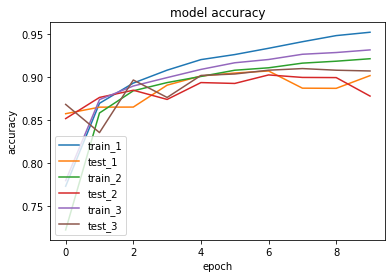

In [ ]:
plot_acc_history(history17,history18,history19)

In [ ]:
files.download("best_model10.hdf5")
files.download("best_model11.hdf5")
files.download("best_model12.hdf5")

files.download("best_model13.hdf5")
files.download("best_model14.hdf5")
files.download("best_model15.hdf5")
files.download("best_model16.hdf5")

files.download("best_model17.hdf5")
files.download("best_model18.hdf5")
files.download("best_model19.hdf5")
files.download("best_model20.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model20 = Sequential()
model20.add(layers.Embedding(max_words, 64, input_length=max_len))
model20.add(layers.Bidirectional(layers.LSTM(40,dropout=0.7)))
model20.add(layers.Dense(4,activation='softmax'))
model20.add(layers.Dense(2,activation='softmax'))


model20.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint20 = ModelCheckpoint("best_model20.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history20 = model20.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),batch_size=128,callbacks=[checkpoint20])

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.7337
Epoch 00001: val_accuracy improved from -inf to 0.86870, saving model to best_model20.hdf5
313/313 [==============================] - 12s 39ms/step - loss: 0.5748 - accuracy: 0.7337 - val_loss: 0.4402 - val_accuracy: 0.8687
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8637
Epoch 00002: val_accuracy did not improve from 0.86870
313/313 [==============================] - 11s 37ms/step - loss: 0.4067 - accuracy: 0.8637 - val_loss: 0.3711 - val_accuracy: 0.8681
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.8800
Epoch 00003: val_accuracy improved from 0.86870 to 0.88800, saving model to best_model20.hdf5
313/313 [==============================] - 11s 37ms/step - loss: 0.3403 - accuracy: 0.8800 - val_loss: 0.3144 - val_accuracy: 0.8880
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.3

## data augmentation models
model 31: 75k aug_1 and 25k processed
model 311: 75k aug_1 and 25k processed
model 32:

In [ ]:
model31 = Sequential() #replicate ogf model 10
model31.add(layers.Embedding(max_words, 40))
model31.add(layers.LSTM(15,dropout=0.7))
model31.add(layers.Dense(2,activation='sigmoid'))

model31.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint31 = ModelCheckpoint("best_model31.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history31 = model31.fit(raw_train, labels_train, epochs=20,validation_data=(raw_test, labels_test),callbacks=[checkpoint31])

Epoch 1/20
819/821 [============================>.] - ETA: 0s - loss: 0.4643 - accuracy: 0.7809
Epoch 00001: val_accuracy improved from -inf to 0.86224, saving model to best_model31.hdf5
821/821 [==============================] - 13s 15ms/step - loss: 0.4640 - accuracy: 0.7810 - val_loss: 0.3413 - val_accuracy: 0.8622
Epoch 2/20
819/821 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8728
Epoch 00002: val_accuracy improved from 0.86224 to 0.87716, saving model to best_model31.hdf5
821/821 [==============================] - 12s 15ms/step - loss: 0.3071 - accuracy: 0.8728 - val_loss: 0.2947 - val_accuracy: 0.8772
Epoch 3/20
818/821 [============================>.] - ETA: 0s - loss: 0.2772 - accuracy: 0.8880
Epoch 00003: val_accuracy did not improve from 0.87716
821/821 [==============================] - 12s 15ms/step - loss: 0.2773 - accuracy: 0.8881 - val_loss: 0.3136 - val_accuracy: 0.8763
Epoch 4/20
818/821 [============================>.] - ETA: 0s - loss: 0.2

In [ ]:
# training data = 75k aug_1 and 25k processed
model311 = Sequential() 
model311.add(layers.Embedding(max_words, 40))
model311.add(layers.LSTM(15,dropout=0.7))
model311.add(layers.Dense(2,activation='sigmoid'))

model311.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint311 = ModelCheckpoint("best_model311.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history311 = model311.fit(raw_train, labels_train, epochs=20,validation_data=(raw_test, labels_test),callbacks=[checkpoint311])

Epoch 1/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.6200 - accuracy: 0.6631
Epoch 00001: val_accuracy improved from -inf to 0.84900, saving model to best_model311.hdf5
3125/3125 [==============================] - 36s 12ms/step - loss: 0.6200 - accuracy: 0.6633 - val_loss: 0.4230 - val_accuracy: 0.8490
Epoch 2/20
3121/3125 [============================>.] - ETA: 0s - loss: 0.5774 - accuracy: 0.7128
Epoch 00002: val_accuracy did not improve from 0.84900
3125/3125 [==============================] - 36s 11ms/step - loss: 0.5774 - accuracy: 0.7127 - val_loss: 0.4605 - val_accuracy: 0.8230
Epoch 3/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.5658 - accuracy: 0.7218
Epoch 00003: val_accuracy did not improve from 0.84900
3125/3125 [==============================] - 36s 11ms/step - loss: 0.5658 - accuracy: 0.7218 - val_loss: 0.4226 - val_accuracy: 0.8361
Epoch 4/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.5593 - accuracy: 0.7283
E

In [ ]:
# training data = 25k processed
model312 = Sequential() 
model312.add(layers.Embedding(max_words, 40))
model312.add(layers.LSTM(15,dropout=0.7))
model312.add(layers.Dense(2,activation='sigmoid'))

model312.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint312 = ModelCheckpoint("best_model312.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history312 = model311.fit(raw_train, labels_train, epochs=20,validation_data=(raw_test, labels_test),callbacks=[checkpoint312])

Epoch 1/20
780/782 [============================>.] - ETA: 0s - loss: 0.3619 - accuracy: 0.8459
Epoch 00001: val_accuracy improved from -inf to 0.84156, saving model to best_model312.hdf5
782/782 [==============================] - 13s 17ms/step - loss: 0.3620 - accuracy: 0.8458 - val_loss: 0.3777 - val_accuracy: 0.8416
Epoch 2/20
778/782 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8622
Epoch 00002: val_accuracy improved from 0.84156 to 0.85296, saving model to best_model312.hdf5
782/782 [==============================] - 13s 17ms/step - loss: 0.3233 - accuracy: 0.8625 - val_loss: 0.3545 - val_accuracy: 0.8530
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8718
Epoch 00003: val_accuracy improved from 0.85296 to 0.85780, saving model to best_model312.hdf5
782/782 [==============================] - 14s 17ms/step - loss: 0.3034 - accuracy: 0.8717 - val_loss: 0.3410 - val_accuracy: 0.8578
Epoch 4/20
781/782 [===========

In [ ]:
# 50k aug_1 + 25k processed
raw_train = review_raw[50000:100000]
labels_train = labels_all[50000:100000]
print(len(raw_train),len(labels_train))

raw_test = review_raw[100000:]
labels_test = labels_all[100000:]
print(len(raw_test),len(labels_test))

model313 = Sequential() 
model313.add(layers.Embedding(max_words, 40))
model313.add(layers.LSTM(15,dropout=0.7))
model313.add(layers.Dense(2,activation='sigmoid'))

model313.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint313 = ModelCheckpoint("best_model313.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history313 = model311.fit(raw_train, labels_train, epochs=5,validation_data=(raw_test, labels_test),callbacks=[checkpoint313])

50000 50000
25000 25000
Epoch 1/5
1562/1563 [============================>.] - ETA: 0s - loss: 0.5257 - accuracy: 0.7265
Epoch 00001: val_accuracy improved from -inf to 0.86252, saving model to best_model313.hdf5
1563/1563 [==============================] - 23s 14ms/step - loss: 0.5256 - accuracy: 0.7265 - val_loss: 0.3789 - val_accuracy: 0.8625
Epoch 2/5
1563/1563 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.7309
Epoch 00002: val_accuracy improved from 0.86252 to 0.86316, saving model to best_model313.hdf5
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5212 - accuracy: 0.7309 - val_loss: 0.3876 - val_accuracy: 0.8632
Epoch 3/5
1560/1563 [============================>.] - ETA: 0s - loss: 0.5164 - accuracy: 0.7333
Epoch 00003: val_accuracy did not improve from 0.86316
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5165 - accuracy: 0.7334 - val_loss: 0.3859 - val_accuracy: 0.8557
Epoch 4/5
1561/1563 [=================

In [ ]:
model32 = Sequential() #replicate ogf model 10
model32.add(layers.Embedding(max_words, 40))
model32.add(layers.LSTM(15,dropout=0.7))
model32.add(layers.Dense(2,activation='sigmoid')) #add one more layer

model32.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint32 = ModelCheckpoint("best_model32.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history32 = model32.fit(raw_train, labels_train, epochs=20,validation_data=(raw_test, labels_test),callbacks=[checkpoint32])

Epoch 1/20
1561/1563 [============================>.] - ETA: 0s - loss: 0.4044 - accuracy: 0.8129
Epoch 00001: val_accuracy improved from -inf to 0.84272, saving model to best_model32.hdf5
1563/1563 [==============================] - 21s 14ms/step - loss: 0.4044 - accuracy: 0.8129 - val_loss: 0.3785 - val_accuracy: 0.8427
Epoch 2/20
1560/1563 [============================>.] - ETA: 0s - loss: 0.2800 - accuracy: 0.8866
Epoch 00002: val_accuracy improved from 0.84272 to 0.87556, saving model to best_model32.hdf5
1563/1563 [==============================] - 21s 13ms/step - loss: 0.2800 - accuracy: 0.8866 - val_loss: 0.3068 - val_accuracy: 0.8756
Epoch 3/20
1560/1563 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.8979
Epoch 00003: val_accuracy improved from 0.87556 to 0.88356, saving model to best_model32.hdf5
1563/1563 [==============================] - 21s 13ms/step - loss: 0.2590 - accuracy: 0.8978 - val_loss: 0.2971 - val_accuracy: 0.8836
Epoch 4/20
1559/1563 [

In [ ]:
model33 = Sequential() #replicate ogf model 10
model33.add(layers.Embedding(max_words, 40))
model33.add(layers.LSTM(15,dropout=0.7))
model33.add(layers.Dense(2,activation='sigmoid')) #add one more layer

model33.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint33 = ModelCheckpoint("best_model33.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history33 = model33.fit(raw_train, labels_train, epochs=20,validation_data=(raw_test, labels_test),callbacks=[checkpoint33])

Epoch 1/20
1560/1563 [============================>.] - ETA: 0s - loss: 0.6158 - accuracy: 0.6583
Epoch 00001: val_accuracy improved from -inf to 0.84920, saving model to best_model33.hdf5
1563/1563 [==============================] - 22s 14ms/step - loss: 0.6158 - accuracy: 0.6584 - val_loss: 0.4523 - val_accuracy: 0.8492
Epoch 2/20
1561/1563 [============================>.] - ETA: 0s - loss: 0.5632 - accuracy: 0.7075
Epoch 00002: val_accuracy did not improve from 0.84920
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5633 - accuracy: 0.7075 - val_loss: 0.4255 - val_accuracy: 0.8315
Epoch 3/20
1560/1563 [============================>.] - ETA: 0s - loss: 0.5483 - accuracy: 0.7193
Epoch 00003: val_accuracy did not improve from 0.84920
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5483 - accuracy: 0.7193 - val_loss: 0.4302 - val_accuracy: 0.8048
Epoch 4/20
1562/1563 [============================>.] - ETA: 0s - loss: 0.5414 - accuracy: 0.7256
Ep